# Synthetic Data

Here we generate and characterise synthetic data with periodic reporting biases.

## Data Generation

This section illustrates the methods used to generate synthetic data with known weekly reporting biases.

In [1]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

from datetime import datetime

from synthetic_data import RenewalModel, Reporter
from analysis import rel_reporting_calc, rel_reporting_violin

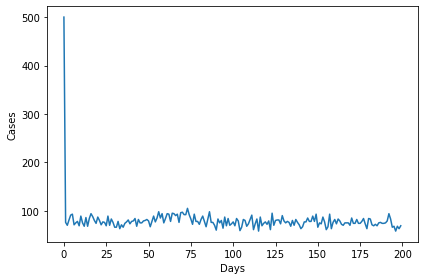

In [2]:
# Simulate Renewal Model
time_steps = 200
N_0 = 500

model = RenewalModel(R0=0.99)
model.simulate(T=time_steps, N_0=N_0)
model.plot()

In [3]:
# Report unbiased and biased data

rep = Reporter(model.case_data)
truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6],
                                multinomial_dist=True)

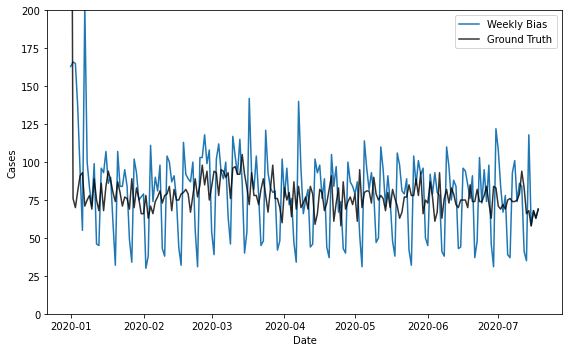

In [4]:
# Plot bias in data

fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
# plt.savefig("../../images/synthetic_examples/"
#             + f"biased_output_T_{time_steps}_N0_{N_0}.png")
plt.show()

Our ultimate aim is to be able to reconstruct the black _'Ground Truth'_ data from the blue _'Weekly Bias'_ data. Naturally, we cannot do this perfectly, due to the stochastic nature of both the original data and the weekly bias.

However, the overall trends of the data may be recovered (in this case case numbers decrease slowly as $R_{0} > 0$), with the underlying $R_{0}$ value inferred?

## Bias Characterisation

We may consider the nature of the weekly reporting bias in a similar way to before.

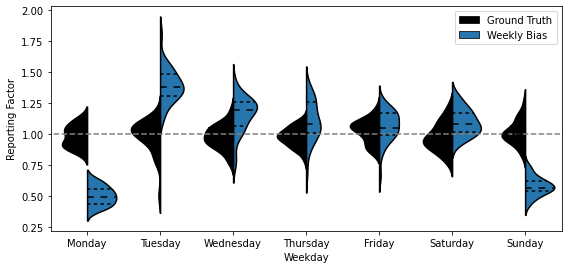

In [5]:
bias_df['Date'] = bias_df['Date'].apply(lambda t: datetime.combine(t, datetime.min.time()))
df = rel_reporting_calc(bias_df, ['Confirmed', 'Ground Truth'])

fig, axs = plt.subplots(1, figsize=(8,4))
rel_reporting_violin(df.copy(), ['Ground Truth', 'Confirmed'],  ax=axs, cutoff=2,
                     colors=['black', 'tab:blue'], labels=["Ground Truth", "Weekly Bias"])  

fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel('Weekday'); plt.ylabel("Reporting Factor")
plt.suptitle(''); plt.tight_layout()
# plt.savefig("../../images/synthetic_examples/"
#             + f"biased_violin_T_{time_steps}_N0_{N_0}.png")

## Delay Distribution

As the number of cases increases, the reporting factors become increasingly well defined. This is not representative of the original data, where there was always a significant spread in the observed reporting factor for a given day of the week.

To avoid this, we could randomly select this reporting factor from an appropriate distribution. By itself, this approach does not conserve the number of cases however, as reporting factors of adjacent days are not in fact independant (i.e. the degree of under-reporting on a given Sunday is directly anticorrelated with the degree of over-reporting the following Tuesday).

We therefore seek an alternative approach that better represents the mechanistic cause of this data. We may assume the ground-truth data on a given day is subject to an unknown delay, determined by a discrete gamma distribution. The length of the tail determines the delay before cases/death take are reported, and may vary between each weekday.

### Paramterisation

Unfortunately determining the length of this delay is non-trivial, and cannot be inferred directly from the data - in fact this problem could be ideal for Bayesian Inference!

Before we can conduct this however, we will give approximate estimates on the appropriate values.

In [6]:
# Bias using delay from discrete gamma distribution

gamma_params = {'shape': [1,1,1,1,1,1,1],
          'rate': [0.5, 2, 2, 2, 2, 2, 0.5]}
gamma_df = rep.delay_distribution_report(params=gamma_params)


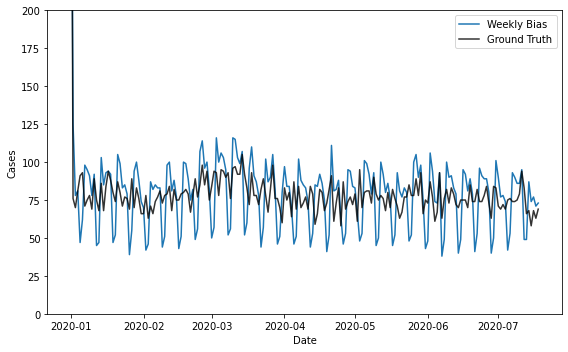

In [7]:
# Plot bias in data

fig, axs = plt.subplots(1, figsize=(8,5))

gamma_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
# plt.savefig("../../images/synthetic_examples/"
#             + f"biased_output_T_{time_steps}_N0_{N_0}.png")
plt.show()

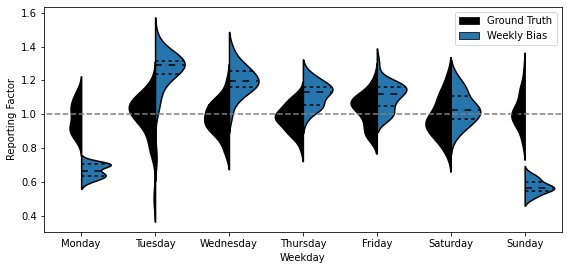

In [8]:
gamma_df['Date'] = gamma_df['Date'].apply(lambda t: datetime.combine(t, datetime.min.time()))
df = rel_reporting_calc(gamma_df, ['Confirmed', 'Ground Truth'])

fig, axs = plt.subplots(1, figsize=(8,4))
rel_reporting_violin(df.copy(), ['Ground Truth', 'Confirmed'],  ax=axs, cutoff=2,
                     colors=['black', 'tab:blue'], labels=["Ground Truth", "Weekly Bias"])  

fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel('Weekday'); plt.ylabel("Reporting Factor")
plt.suptitle(''); plt.tight_layout()
# plt.savefig("../../images/synthetic_examples/"
#             + f"gamma_biased_violin_T_{time_steps}_N0_{N_0}.png")